# Stocks Price Prediction With GPR

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF, Matern, RationalQuadratic, ExpSineSquared
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import quandl
from sklearn import preprocessing
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0

## Config your hyperparameters here.

In [2]:
stock_id = 'WIKI/NVDA' # the stock you want to get
input_data_length = 100 # length of input data
predict_data_length = 50 # how many day to predict
# [Important] choice of kernel
kernel = 0.2*RBF(1.5) + 3*RBF(0.3) + WhiteKernel(noise_level=1e-3) + Matern() + RationalQuadratic()*0.1 + ExpSineSquared()*0.2

## Get Data

In [3]:
# Get data via Quandl API
data = quandl.get(stock_id)

## Preprocess Data
Note: the normalization will remarkably eaze the pain of tuning.

In [4]:
y = np.array(data.Open[:input_data_length]).reshape(-1,1)
x = np.arange(len(y)).reshape(-1,1)
scaler = preprocessing.StandardScaler().fit(y)
y = scaler.transform(y)


## Fit GPR model and Predict

In [5]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)
gpr.fit(x, y)
x_new = np.arange(0, len(x)+predict_data_length).reshape(-1,1)
y_hat, y_sigma = gpr.predict(x_new, return_std=True)

## Plot Data

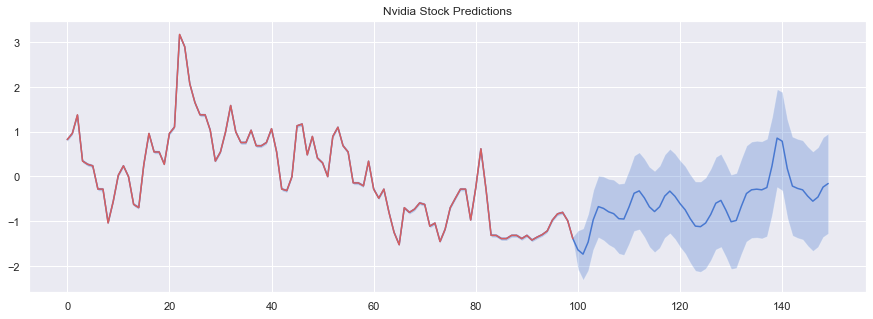

In [6]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(15, 5))
# plot predict data
y_hat = np.squeeze(y_hat)
ax.plot(x_new, y_hat, 'b')
lower = y_hat - y_sigma
upper = y_hat + y_sigma
ax.fill_between(x_new.flatten(), lower, upper, alpha=0.3)
# plot original data
ax.plot(x, y, 'r')
plt.title("Nvidia Stock Predictions")
plt.show()